<a href="https://colab.research.google.com/github/ehsankarami1358/ehsan/blob/main/SVM01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/amir-saniyan/HodaDatasetReader.git


Cloning into 'HodaDatasetReader'...
remote: Enumerating objects: 24, done.
remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24 (from 1)
Receiving objects: 100% (24/24), 6.34 MiB | 6.76 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
import matplotlib.pyplot as plt
from HodaDatasetReader.HodaDatasetReader import read_hoda_dataset
import numpy as np
import pandas as pd

In [3]:
# *-* coding: utf-8 *-*

# Hoda Dataset Reader
# Python code for reading Hoda farsi digit dataset.

# Hoda Farsi Digit Dataset:
# http://farsiocr.ir/
# http://farsiocr.ir/مجموعه-داده/مجموعه-ارقام-دستنویس-هدی
# http://dadegan.ir/catalog/hoda

# Repository:
# https://github.com/amir-saniyan/HodaDatasetReader

import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int32)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y


In [4]:
X_train,y_train=read_hoda_dataset('/content/HodaDatasetReader/DigitDB/Train 60000.cdb')
X_test,y_test=read_hoda_dataset('/content/HodaDatasetReader/DigitDB/Test 20000.cdb')

In [5]:
X_train.shape

(60000, 1024)

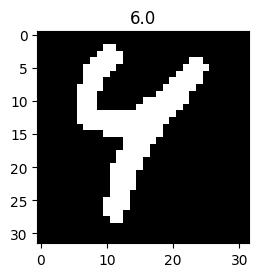

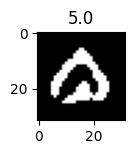

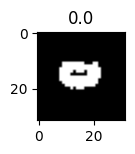

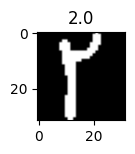

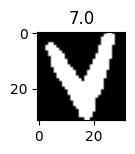

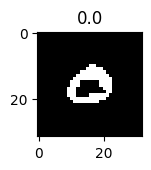

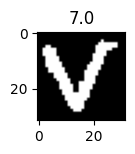

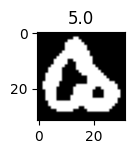

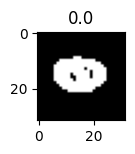

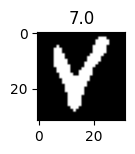

In [6]:
plt.figure(figsize=(12,5))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(X_train[i].reshape(32,32),cmap='gray')
  plt.title(y_train[i])
  plt.tight_layout()
  plt.show()

In [7]:
from time import perf_counter
tr_time_start=perf_counter()
from sklearn.svm import SVC
#c represents the margin(soft/hard=:c high --> hard margin/c low --> soft margin
hoda_svc=SVC(kernel='rbf',C=0.01)
hoda_svc.fit(X_train[:10000],y_train[:10000])
tr_time_end=perf_counter()
print(f'training acc: {hoda_svc.score(X_train,y_train)}')
print(f'training time: {tr_time_end-tr_time_start}')

training acc: 0.8834
training time: 93.26641177099998


In [8]:
ts_time_start=perf_counter()
hoda_svc.score(X_test,y_test)
ts_time_end=perf_counter()
print(f'test acc: {hoda_svc.score(X_test,y_test)}')
print(f'time span test phase: {ts_time_end-ts_time_start}')
#

test acc: 0.78825
time span test phase: 234.23093596399997
